# Emotion Classification of Tweets

### Import libraries and load dataset.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

2024-04-19 02:12:15.618684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 02:12:15.618892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 02:12:15.832592: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/emotions/text.csv')
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


#### Description of Data
<ul>
    <li><strong>text</strong> - A string feature representing the content of the Twitter message.</li>
    <li><strong>label</strong> - A classification label indicating the primary emotion, with values ranging from 0 to 5.</li>
    <ul>
        <li><strong>0</strong> - sadness</li>
        <li><strong>1</strong> - joy</li>
        <li><strong>2</strong> - love</li>
        <li><strong>3</strong> - anger</li>
        <li><strong>3</strong> - fear</li>
        <li><strong>3</strong> - surprise</li>
    </ul>
</ul>

### Check for missing, Null or duplicate values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  416809 non-null  int64 
 1   text        416809 non-null  object
 2   label       416809 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.5+ MB


In [3]:
df.duplicated().sum()

0

### Get rid of unneeded data.

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

### Count the Emotion Labels.

Rename existing features.

In [5]:
df.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)

Copy the dataset to be used in data analysis.

In [6]:
label_df = df.copy()

Change numerical encoding to text-based enconding. 
sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [7]:
label_df['Label'] = label_df['Label'].replace(0,'Sadness')
label_df['Label'] = label_df['Label'].replace(1,'Joy')
label_df['Label'] = label_df['Label'].replace(2,'Love')
label_df['Label'] = label_df['Label'].replace(3,'Anger')
label_df['Label'] = label_df['Label'].replace(4,'Fear')
label_df['Label'] = label_df['Label'].replace(5,'Surprise')

Plot the count of each emotion.

<Axes: xlabel='Label', ylabel='count'>

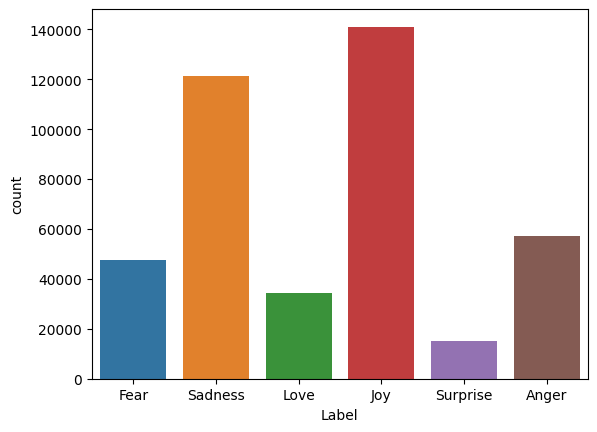

In [8]:
sns.countplot(x ='Label', data = label_df)

### Create Seperate Data for Word Clouds.

In [9]:
df_sadness = label_df[label_df['Label']=='Sadness']
df_joy = label_df[label_df['Label']=='Joy']
df_love = label_df[label_df['Label']=='Love']
df_anger = label_df[label_df['Label']=='Anger']
df_fear = label_df[label_df['Label']=='Fear']
df_surprise = label_df[label_df['Label']=='Surprise']

Combine text from different emotions.

In [10]:
combined_all_text = ' '.join(df['Text'])
combined_sadness_text = ' '.join(df_sadness['Text'])
combined_joy_text = ' '.join(df_joy['Text'])
combined_love_text = ' '.join(df_love['Text'])
combined_anger_text = ' '.join(df_anger['Text'])
combined_fear_text = ' '.join(df_fear['Text'])
combined_surprise_text = ' '.join(df_surprise['Text'])

Create WordClouds.

In [11]:
all_wordcloud = WordCloud(background_color='white').generate(combined_all_text)
sadness_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_sadness_text)
joy_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_joy_text)
love_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_love_text)
anger_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_anger_text)
fear_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_fear_text)
surprise_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_surprise_text)

Plot the WordClouds.

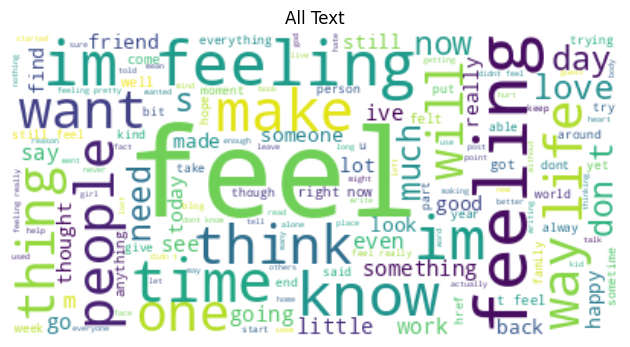

In [13]:
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.title('All Text')
plt.axis('off')

plt.tight_layout()
# plt.savefig("alltext.jpg", dpi=300)
plt.show()


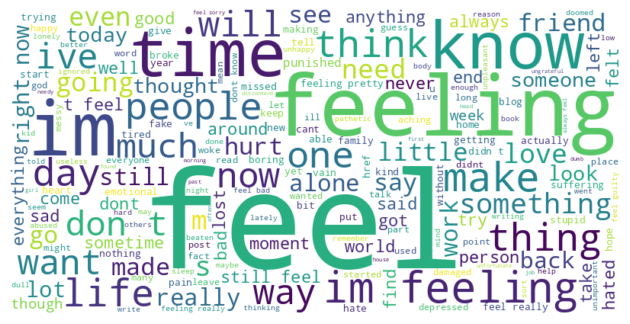

In [14]:
# plt.imshow(sadness_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("sadness.jpg", dpi=300)
# plt.show()

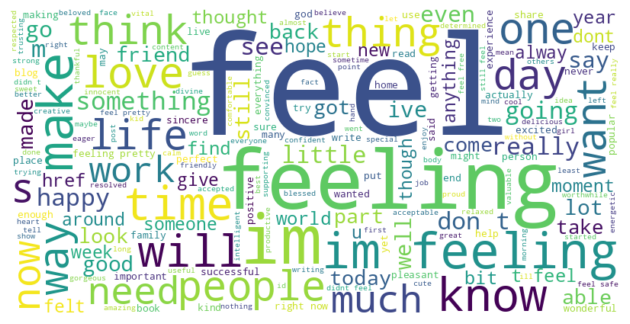

In [15]:
# plt.imshow(joy_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("joy.jpg", dpi=300)
# plt.show()

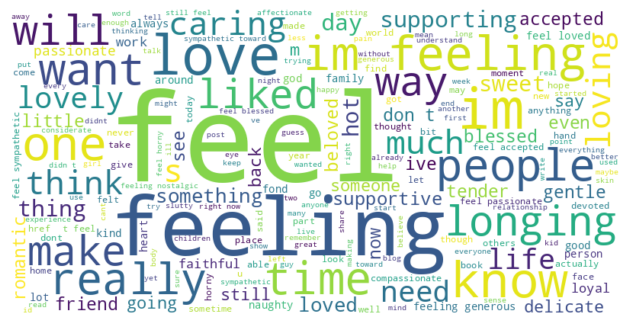

In [16]:
# plt.imshow(love_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("love.jpg", dpi=300)
# plt.show()

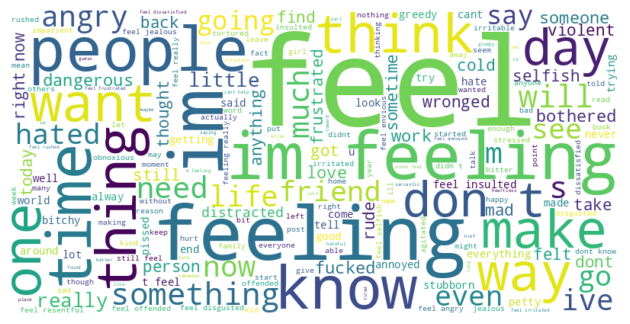

In [17]:
# plt.imshow(anger_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("anger.jpg", dpi=300)
# plt.show()

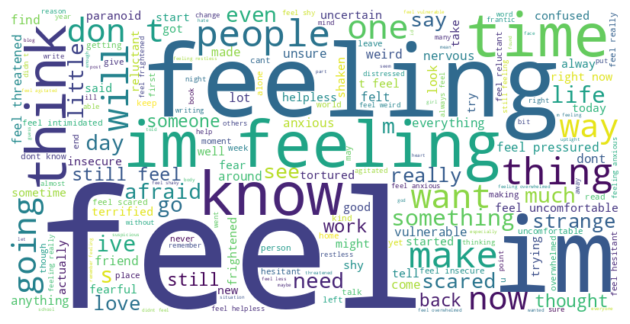

In [18]:
# plt.imshow(fear_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("fear.jpg", dpi=300)
# plt.show()

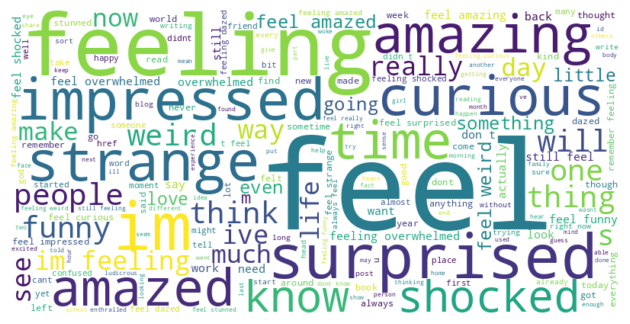

In [19]:
# plt.imshow(surprise_wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig("surprise.jpg", dpi=300)
# plt.show()

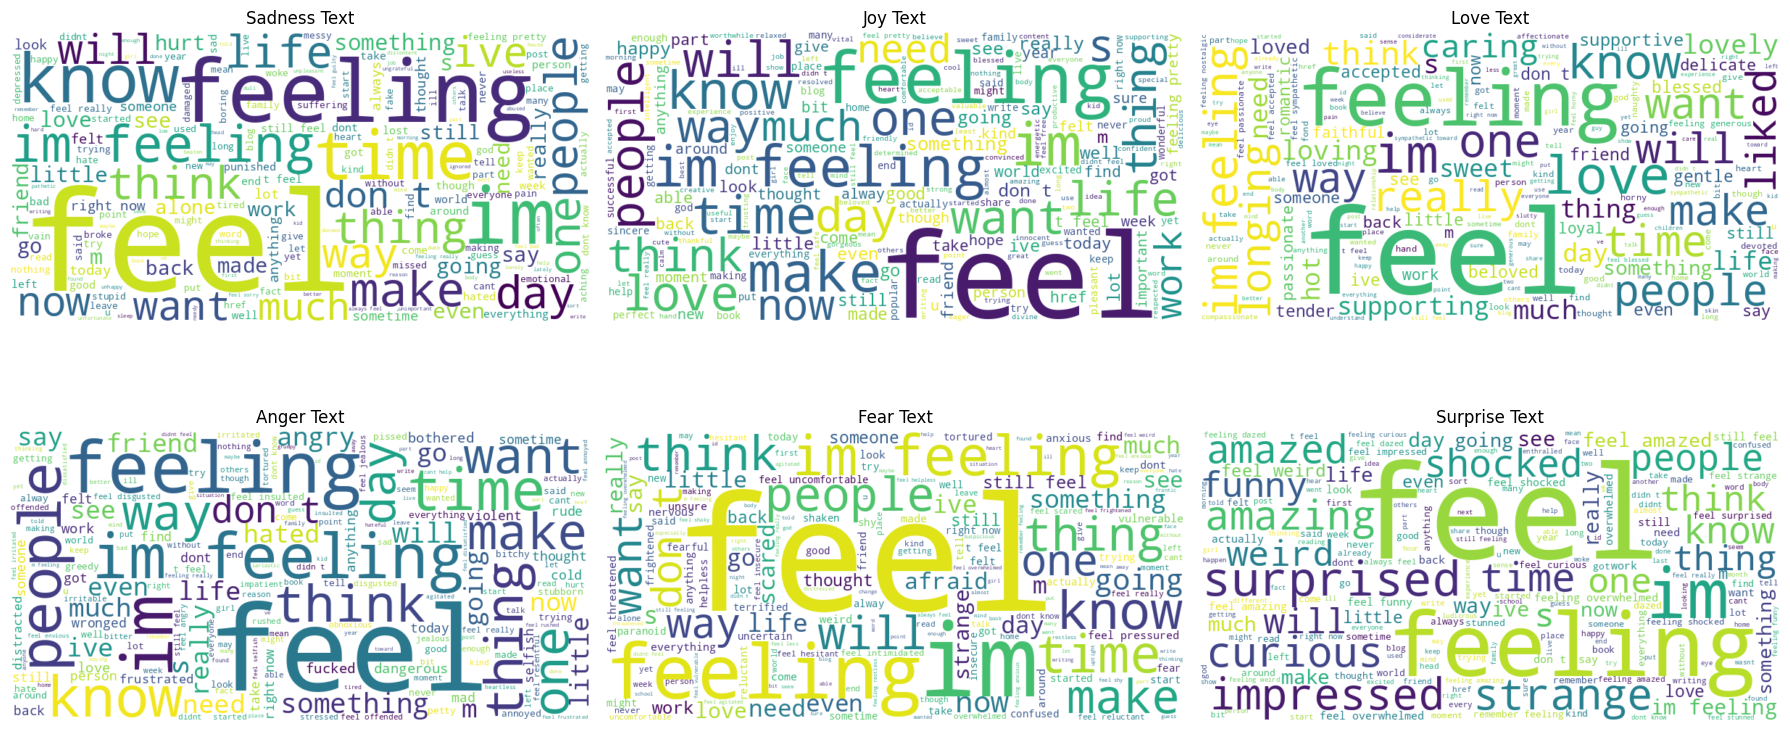

In [14]:
plt.figure(figsize=(18, 9))

plt.subplot(2, 3, 1)
plt.imshow(sadness_wordcloud, interpolation='bilinear')
plt.title('Sadness Text')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(joy_wordcloud, interpolation='bilinear')
plt.title('Joy Text')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(love_wordcloud, interpolation='bilinear')
plt.title('Love Text')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(anger_wordcloud, interpolation='bilinear')
plt.title('Anger Text')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(fear_wordcloud, interpolation='bilinear')
plt.title('Fear Text')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(surprise_wordcloud, interpolation='bilinear')
plt.title('Surprise Text')
plt.axis('off')

plt.tight_layout()
plt.show()

# Text Preprocessing

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Remove URLs.

In [16]:
df['Text'] = df['Text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove special characters and puctuation.

In [17]:
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove extra whitespaces.

In [18]:
df['Text'] = df['Text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove Numeric Values in Text.

In [19]:
df['Text'] = df['Text'].str.replace(r'\d+', '', regex=True)
df.head()

,Text,Label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


### Lowercase all text.

In [20]:
df['Text'] = df['Text'].str.lower()
print(df.head())

                                                Text  Label
0      i just feel really helpless and heavy hearted      4
1  ive enjoyed being able to slouch about relax a...      0
2  i gave up my internship with the dmrg and am f...      4
3                         i dont know i feel so lost      0
4  i am a kindergarten teacher and i am thoroughl...      4


### Remove Stopwords.

In [21]:
stop = stopwords.words('english')
df["Text"] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


### Remove all non-alpha numeric characters.

In [22]:
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df.head()

,Text,Label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


# Create the Train/Test Split

In [23]:
X = df['Text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Tokenization and Padding Sequences

### Tokenize the 'Text' feature.

In [24]:
tokenizer = Tokenizer(num_words=50000)
# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
# Transforms each text in texts to a sequence of integers.
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

### Maximum Length in X_train_sequences

In [25]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
maxlen

79

### Perform padding on X_train and X_test sequences.

In [26]:
# Pad sequences to the same length.
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen)

### Define Input Size.

In [27]:
input_Size = np.max(X_train_padded) + 1
input_Size

50000

# The Model

### Build the model.

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [28]:
# Define the model
model = Sequential()

# Add embedding layer
model.add(Embedding(input_dim=input_Size, output_dim=50))


# Dropout
model.add(Dropout(0.15))

# Add Bidirectional LSTM layer
model.add(Bidirectional(GRU(120, return_sequences=True)))
model.add(Bidirectional(GRU(64, return_sequences=True)))

#Batch Normalization
model.add(BatchNormalization())

# Add Bidirectional GRU layer
model.add(Bidirectional(GRU(64)))

# Add output layer
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit the Model.

In [29]:
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=1500, validation_data=(X_test_padded, y_test))

Epoch 1/4
223/223 ━━━━━━━━━━━━━━━━━━━━ 1289s 6s/step - accuracy: 0.6412 - loss: 0.9232 - val_accuracy: 0.8814 - val_loss: 0.6400
Epoch 2/4
223/223 ━━━━━━━━━━━━━━━━━━━━ 1263s 6s/step - accuracy: 0.9356 - loss: 0.1177 - val_accuracy: 0.9322 - val_loss: 0.1303
Epoch 3/4
223/223 ━━━━━━━━━━━━━━━━━━━━ 1262s 6s/step - accuracy: 0.9426 - loss: 0.0912 - val_accuracy: 0.9348 - val_loss: 0.1011
Epoch 4/4
223/223 ━━━━━━━━━━━━━━━━━━━━ 1264s 6s/step - accuracy: 0.9448 - loss: 0.0847 - val_accuracy: 0.9337 - val_loss: 0.1033


93.65% after 2 epochs.

### Model parameters.

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 79, 50)         │     2,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 79, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 79, 240)        │       123,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 79, 128)        │       117,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 79, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        74,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,450,868 (32.24 MB)

 Trainable params: 2,816,870 (10.75 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 5,633,742 (21.49 MB)

### Visualize Results.

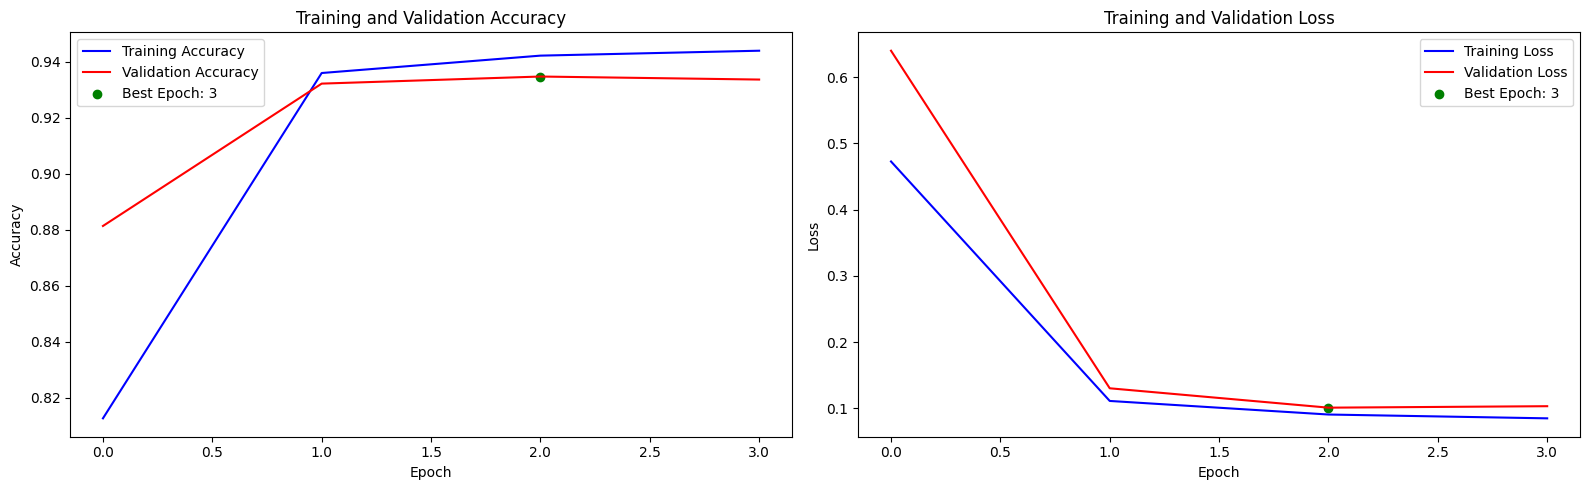

In [31]:
# Get the epoch with the highest validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()


# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# Evaluate the Model

In [32]:
model.evaluate(X_test_padded, y_test)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 161s 62ms/step - accuracy: 0.9349 - loss: 0.1023


[0.1033765971660614, 0.9336748123168945]

### Make predictions.

In [33]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 160s 61ms/step


### The Confusion Matrix.

In [34]:
y_test

80876     2
364314    3
345676    0
120252    0
405143    1
         ..
357083    3
382177    4
407319    0
33992     4
276657    1
Name: Label, Length: 83362, dtype: int64

In [35]:
y_pred

array([2, 3, 0, ..., 0, 4, 2])

<Axes: >

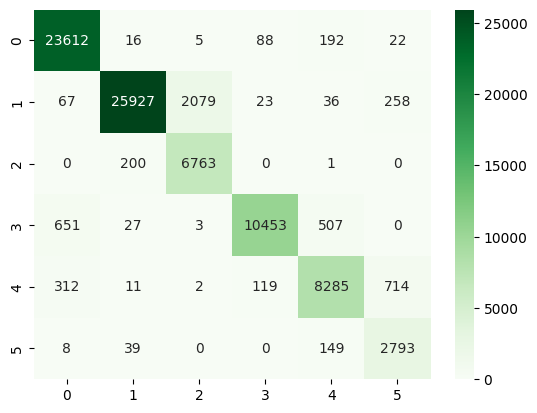

In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')

Remember that sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

<Axes: xlabel='Label', ylabel='count'>

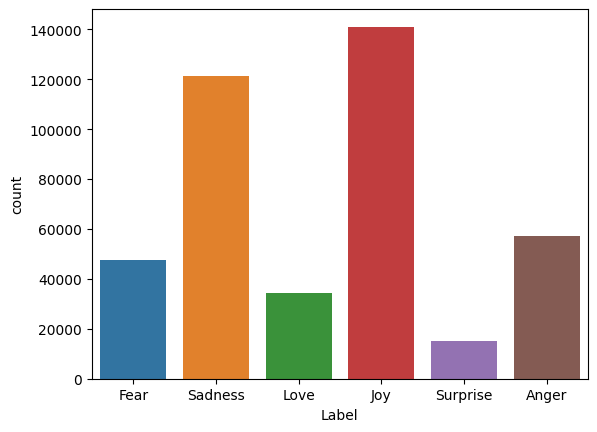

In [37]:
sns.countplot(x ='Label', data = label_df)